## 2-Qubit Randomized Benchmarking
---
**John A. Smolin, David McKay, Yael Ben-Haim and Shelly Garion**


* **Last Updated:** Feb 14, 2019
* **Requires:** qiskit-terra 0.7

This notebook generates sequences for running 2-qubit randomized benchmarking. 


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error

import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

# Import the RB Functions
import qiskit_ignis.randomized_benchmarking.standard_rb.randomizedbenchmarking as rb

#import the RB fitter
import qiskit_ignis.randomized_benchmarking.standard_rb.rb_fitters as rb_fitters

## Select the Parameters of the RB Run

In [35]:
#number of qubits
nQ = 3
#number of seeds (random sequences)
nseeds = 5
#number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

## Generate RB sequences

We generate RB sequences. We start a small example (so it doesn't take too long to run). In this example we are running 2Q, 1Q simultaneous RB where there are twice as many 1Q Clifford gates.

In [36]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = [[0,2],[1]]
rb_opts['length_multiplier'] = [1,2]
rb_opts['n_qubits'] = nQ
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence

In [37]:
print(rb_circs[0][0])

         ┌───┐┌─────┐┌─────┐          ┌───┐     ┌─────┐┌───┐┌─────┐┌───┐┌─────┐»
qr_0: |0>┤ H ├┤ Sdg ├┤  H  ├──■───────┤ X ├─────┤ Sdg ├┤ H ├┤ Sdg ├┤ H ├┤  X  ├»
         ├───┤└──░──┘├─────┤  │  ┌───┐└─┬─┘┌───┐└──░──┘├───┤├─────┤├───┤├─────┤»
qr_1: |0>┤ Y ├───░───┤ Sdg ├──┼──┤ H ├──┼──┤ Y ├───░───┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├»
         ├───┤   ░   └─────┘┌─┴─┐└───┘  │  └───┘┌─────┐├───┤├─────┤├───┤├─────┤»
qr_2: |0>┤ H ├──────────────┤ X ├───────■───────┤ Sdg ├┤ H ├┤ Sdg ├┤ H ├┤  X  ├»
         └───┘              └───┘               └─────┘└───┘└─────┘└───┘└─────┘»
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

## Look at the Unitary for 1 Circuit

Unitary of each RB circuit should be the identity. Simulate using Aer.

In [38]:
#Create a new circuit without the measurement
qc = qiskit.QuantumCircuit(*rb_circs[0][-1].qregs,*rb_circs[0][-1].cregs)
for i in rb_circs[0][-1][0:-nQ]:
    qc._attach(i)

In [39]:
backend = qiskit.Aer.get_backend('unitary_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
job = qiskit.execute(qc, backend=backend, basis_gates=basis_gates)
print(np.around(job.result().get_unitary(),3))

[[-0.707-0.707j -0.   +0.j     0.   +0.j     0.   +0.j     0.   -0.j
   0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.707-0.707j  0.   +0.j     0.   +0.j     0.   +0.j
   0.   -0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.707-0.707j -0.   +0.j     0.   +0.j
   0.   +0.j     0.   -0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j    -0.707-0.707j  0.   -0.j
   0.   +0.j     0.   +0.j     0.   -0.j   ]
 [ 0.   -0.j    -0.   +0.j     0.   +0.j     0.   +0.j    -0.707-0.707j
   0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j
  -0.707-0.707j  0.   +0.j    -0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   -0.j    -0.   +0.j     0.   +0.j
   0.   +0.j    -0.707-0.707j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     0.   -0.j     0.   +0.j
   0.   +0.j     0.   +0.j    -0.707-0.707j]]


## Define the noise model

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [40]:
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.002, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.002, 2), 'cx')
#noise_model = None

## Execute on Aer simulator

In [ ]:
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
basis_gates_str = ','.join(basis_gates)
shots = 1024
result_list = []
qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    qobj = qiskit.compile(rb_circ_seed, backend=backend, basis_gates=basis_gates_str)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    result_list.append(job.result())
    qobj_list.append(qobj)    
print("Finished Simulatoing")

## Get statistics about the survival probabilities

In [42]:
#create an RBFitter object with 1 seed of data
rbfit = rb_fitters.RBFitter([result_list[0]], xdata, shots, rb_opts['rb_pattern'])

### Plot After 1 Seed

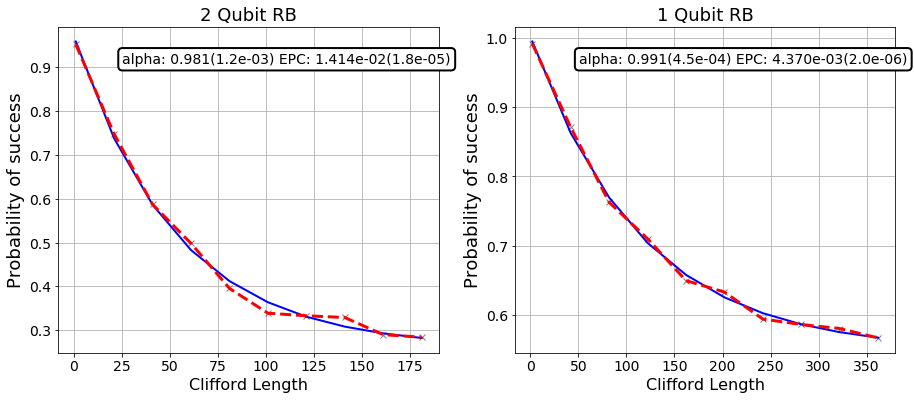

In [43]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)
    ax.set_ylabel('Probability of success', fontsize=18)
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)

    # Add more information
    ax.text(0.6, 0.9,
            "alpha: %.3f(%.1e) EPC: %.3e(%.1e)"
            %(rbfit.fit[pattern_ind]['params'][1], rbfit.fit[pattern_ind]['params_err'][1], 
              rbfit.fit[pattern_ind]['epc'], rbfit.fit[pattern_ind]['epc_err']),
            ha="center", va="center", size=14, bbox=bbox_props, transform=ax.transAxes)

plt.show()

In [44]:
#add the rest of the data
rbfit.add_data(result_list[1:])

### Plot with the Rest of the Seeds

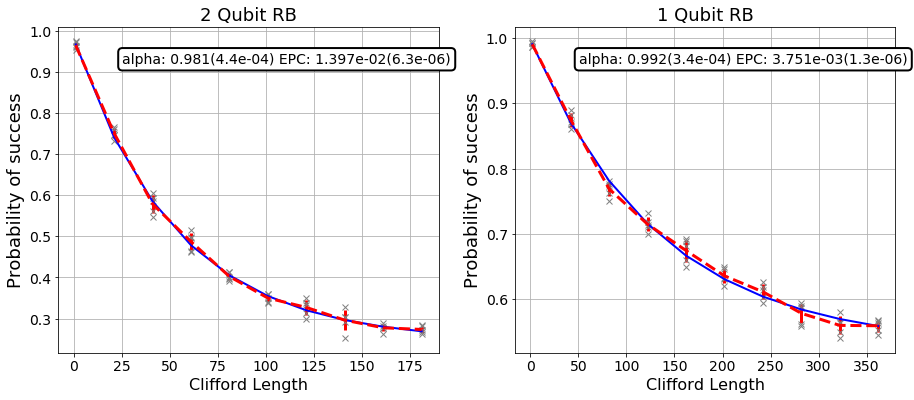

In [45]:
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=ax, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)
    ax.set_ylabel('Probability of success', fontsize=18)
    bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=2)

    # Add more information
    ax.text(0.6, 0.9,
            "alpha: %.3f(%.1e) EPC: %.3e(%.1e)"
            %(rbfit.fit[pattern_ind]['params'][1], rbfit.fit[pattern_ind]['params_err'][1], 
              rbfit.fit[pattern_ind]['epc'], rbfit.fit[pattern_ind]['epc_err']),
            ha="center", va="center", size=14, bbox=bbox_props, transform=ax.transAxes)

plt.show()